In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np

door1 = pd.read_csv("data/data_door1.txt",  sep=";", header=None)
door1 = door1.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)


In [2]:
def calculateMedian(i, variable, size):        
    start = max(i - size, 0) 
    end = min(i, len(variable)) 

    calculate_median = variable[start:end]
    calculate_median.sort()
    if(len(calculate_median) > 0): median = calculate_median[len(calculate_median)//2]
    else: median = variable[i]
        
    return median

def rolling_media(i, variable, size, variableMedian):
    median = calculateMedian(i, variable, size)
    variableMedian.append(median)
    
def cummulative_sum(i, variableMedian, gMax, gMin, drift):
        s_i = variableMedian[i] - variableMedian[i-1]
        gMax_i = max(gMax[i-1] + s_i - drift, 0)
        gMin_i = max(gMin[i-1] - s_i - drift, 0)
        gMax.append(gMax_i)
        gMin.append(gMax_i)
                
        return gMax_i, gMin_i
    
def removeMaxTop(i, cleanChange):
    j = i - 1
    while(cleanChange[j] > 0 and j > 0):
        cleanChange[j] = 0
        j -= 1

def removeMinTop(i, cleanChange):
    j = i - 1
    while(cleanChange[j] < 0 and j > 0):
        cleanChange[j] = 0
        j -= 1
        
def deleteSmallTops(lastZero, cleanChange, globalMax, coef2, position):
    j = lastZero                                  # Delete movements smallers that 50% global maximim
    while(j > 0): 
        try:
            if(position == "max"):
                if(cleanChange[j] < globalMax*coef2): cleanChange[j] = min(0, cleanChange[j])
            elif(position == "min"):
                if(cleanChange[j] > globalMax*coef2): cleanChange[j] = max(0, cleanChange[j])
        except:
            print("error at: ",j)
        j -= 1

def isLocalMax(i, change):
    return change[i] == 0 and change[i-1] > 0

def updateLastZero(i, change, lastZero):
    if(change[i] == 0): lastZero = i
        
def isLocalMin(i, change):
    return change[i] == 0 and change[i-1] < 0

In [3]:
x = list(door1.x)
z = list(door1.z)
y = list(door1.y)

### MEDIAN values #####

windowSize = 100                # Size of the median window
y_windowSize = 100
x_median = list()   # median stored
z_median = list()
y_median = list()

#### CUSUM values #####

x_drift = 0.07              # drift: CUSUM parameter
x_threshold = 0.01          # threshold: CUSUM parameter
z_drift = 0.07
z_threshold = 0.03
y_drift = 0.011
y_threshold = 0.005

x_alarms = list()           # Points where a movement change is detected
x_opening = list()          # Points when an upward movement is detected
x_closing = list()          # Points when an downward movement is detected
z_alarms = list()           
z_opening = list()          
z_closing = list()   
y_alarms = list()           
y_opening = list()          
y_closing = list()  
            
x_gMax = list([0]) # internal variables for CUSUM
x_gMin = list([0])
z_gMax = list([0])
z_gMin = list([0])
y_gMax = list([0])
y_gMin = list([0])

### STEP Detection ####

#alarmDetected = False
alarmInterval = 10             # Alarms closer than this will be considerated consecutive
y_alarmInterval = 50
x_alarmCounter = 0               # Counter of consecutive alarms
x_change = list()                # Cumulative alarms
z_alarmCounter = 0               
z_change = list()                
y_alarmCounter = 0               
y_change = list()   

x_closingDetected = False
x_openingDetected = False
x_lastAlarm = -1                 # Index of last alarm
z_closingDetected = False
z_openingDetected = False
z_lastAlarm = -1   
y_closingDetected = False
y_openingDetected = False
y_lastAlarm = -1   


### Slope ponderation ####

x_slope = list([0])              # Storing slope
z_slope = list([0])              
y_slope = list([0])    


### Clean change (remove errors online)

clean_y_change = list()
globalMax_y = 0
globalMin_y = 100000
lastZero_y = 0   # Last zero before movement

clean_x_change = list()
globalMax_x = 0
globalMin_x = 100000
lastZero_x = 0   # Last zero before movement

clean_z_change = list()
globalMax_z = 0
globalMin_z = 100000
lastZero_z = 0   # Last zero before movement

coef1 = 1.2
coef2 = 0.5

In [4]:
for i in range(0, 500000):
    
    ### MEDIAN calculation #####
    # Calculate median of raw data     
    rolling_media(i, x, windowSize, x_median)
    rolling_media(i, z, windowSize, z_median)
    rolling_media(i, y, y_windowSize, y_median)

    ###### CUSUM intervals #####
    # Detect growing and decreasing tendences on the median,
    # Results in a list of indexes of changes
    if(i != 0): 
        x_gMax_i, x_gMin_i = cummulative_sum(i, x_median, x_gMax, x_gMin, x_drift)
        
        x_alarmDetected = x_gMax_i > x_threshold or x_gMin_i > x_threshold
        if(x_alarmDetected): x_alarms.append(i)

        x_openingDetected = x_gMax_i > x_threshold
        if(x_openingDetected): x_opening.append(i)

        x_closingDetected = x_gMin_i > x_threshold
        if(x_closingDetected): x_closing.append(i)   
            
        ####
        
        z_gMax_i, z_gMin_i = cummulative_sum(i, z_median, z_gMax, z_gMin, z_drift)
        
        z_alarmDetected = z_gMax_i > z_threshold or z_gMin_i > z_threshold
        if(z_alarmDetected): z_alarms.append(i)

        z_openingDetected = z_gMax_i > z_threshold
        if(z_openingDetected): z_opening.append(i)

        z_closingDetected = z_gMin_i > z_threshold
        if(z_closingDetected): z_closing.append(i)  
            
        ####
        
        y_gMax_i, y_gMin_i = cummulative_sum(i, y_median, y_gMax, y_gMin, y_drift)
        
        y_alarmDetected = y_gMax_i > y_threshold or y_gMin_i > y_threshold
        if(y_alarmDetected): y_alarms.append(i)

        y_openingDetected = y_gMax_i > y_threshold
        if(y_openingDetected): y_opening.append(i)

        y_closingDetected = y_gMin_i > y_threshold
        if(y_closingDetected): y_closing.append(i)  
        

    ### Slope ponderation ####
    # Calculate the slope of the median to ponderate with the added value in case 
    # of positive alarm. Helps define the intervals with more precision, solve errors
    # in definition and provides an aproximation of speed
    
    # (fun(i) - fun(j) / (i-j)) # i-j is constant, j = i - 1
    if(i != 0): 
        x_slope.append(x_median[i] - x_median[i-1])
        z_slope.append(z_median[i] - z_median[i-1])
        y_slope.append(y_median[i] - y_median[i-1])
        
    
    #### Step Detection #####
    # Apply ponderation an calculate cumulative movement
    
    if(x_openingDetected or x_closingDetected):
        x_alarmCounter += (1 * x_slope[i])
        x_lastAlarm = i   
    elif(x_lastAlarm > i - alarmInterval):  # Interval exceded
        x_alarmCounter += (1 * x_slope[i])
    else:
        x_alarmCounter = 0 
    x_change.append(x_alarmCounter)
    
    ####
    
    if(z_openingDetected or z_closingDetected):
        z_alarmCounter += (1 * z_slope[i])
        z_lastAlarm = i   
    elif(z_lastAlarm > i - alarmInterval):  # Interval exceded
        z_alarmCounter += (1 * z_slope[i])
    else:
        z_alarmCounter = 0 
    z_change.append(z_alarmCounter)
    
    ####
    
    if(y_openingDetected or y_closingDetected):
        y_alarmCounter += (1 * y_slope[i])
        y_lastAlarm = i   
    elif(y_lastAlarm > i - y_alarmInterval):  # Interval exceded
        y_alarmCounter += (1 * y_slope[i])
    else:
        y_alarmCounter = 0 
    y_change.append(y_alarmCounter)
    
    
    ### Cleaning change vector ####
    
    if(i == 0):
        clean_x_change = list([x_change[0]])
        clean_y_change = list([y_change[0]])
        clean_z_change = list([z_change[0]])

    
    else:
        if(y_change[i] == 0): lastZero_y = i                        # Update Last zero     
    
        localMax = isLocalMax(i, y_change)                          # Check if position is a local maximum

        if(localMax):
            isGlobal = y_change[i-1] > globalMax_y*coef1  # Local maximum is global
            deleteTop = y_change[i-1] < globalMax_y*coef2

            if (isGlobal):                  
                globalMax_y = y_change[i-1]
                deleteSmallTops(lastZero_y, clean_y_change, globalMax_y, coef2, "max")

            elif(deleteTop):                 # Local top is not global and smaller than 50% global: delete
                removeMaxTop(i, clean_y_change)

        localMin = isLocalMin(i, y_change)
        if(localMin): 
            isGlobal = y_change[i-1] < globalMin_y*coef2
            deleteTop = y_change[i-1] > globalMin_y*coef2

            if (isGlobal):                   # Local minimum is global
                globalMin_y = y_change[i-1]
                deleteSmallTops(lastZero_y, clean_y_change, globalMin_y, coef2, "min")

            elif(deleteTop):                  # Local min is not global and smaller than 50% global: delete
                removeMinTop(i, clean_y_change)

          ####

        updateLastZero(i, x_change, lastZero_x)                         # Update Last zero     
        localMax = isLocalMax(i, x_change)                          # Check if position is a local maximum

        if(localMax):
            isGlobal = x_change[i-1] > globalMax_x*coef1  # Local maximum is global
            deleteTop = x_change[i-1] < globalMax_x*coef2

            if (isGlobal):                  
                globalMax_x = x_change[i-1]
                deleteSmallTops(lastZero_x, clean_x_change, globalMax_x, coef2, "max")

            elif(deleteTop):                 # Local top is not global and smaller than 50% global: delete
                removeMaxTop(i, clean_x_change)


            localMin = isLocalMin(i, y_change)

        if(localMin): 
            isGlobal = x_change[i-1] < globalMin_x*coef2
            deleteTop = x_change[i-1] > globalMin_x*coef2

            if (isGlobal):                   # Local minimum is global
                globalMin_x = x_change[i-1]
                deleteSmallTops(lastZero_x, clean_x_change, globalMin_x, coef2, "min")

            elif(deleteTop):                  # Local min is not global and smaller than 50% global: delete
                removeMinTop(i, clean_x_change)


        ####


        updateLastZero(i, z_change, lastZero_z)                         # Update Last zero     
        localMax = isLocalMax(i, z_change)                          # Check if position is a local maximum

        if(localMax):
            isGlobal = z_change[i-1] > globalMax_z*coef1  # Local maximum is global
            deleteTop = z_change[i-1] < globalMax_z*coef2

            if (isGlobal):                  
                globalMax_z = z_change[i-1]
                deleteSmallTops(lastZero_z, clean_z_change, globalMax_z, coef2, "max")

            elif(deleteTop):                 # Local top is not global and smaller than 50% global: delete
                removeMaxTop(i, clean_z_change)


            localMin = isLocalMin(i, z_change)

        if(localMin): 
            isGlobal = z_change[i-1] < globalMin_z*coef2
            deleteTop = z_change[i-1] > globalMin_z*coef2

            if (isGlobal):                   # Local minimum is global
                globalMin_z = z_change[i-1]
                deleteSmallTops(lastZero_z, clean_z_change, globalMin_z, coef2, "min")

            elif(deleteTop):                  # Local min is not global and smaller than 50% global: delete
                removeMinTop(i, clean_z_change)

        ####

        clean_y_change.append(y_change[i])
        clean_x_change.append(x_change[i])
        clean_z_change.append(z_change[i])


### TESTS

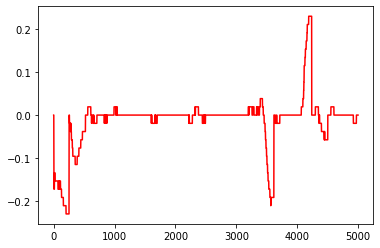

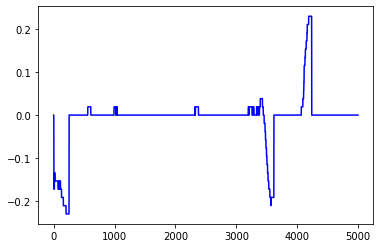

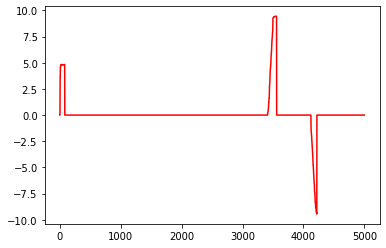

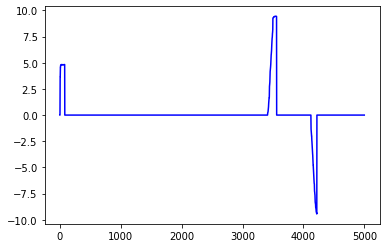

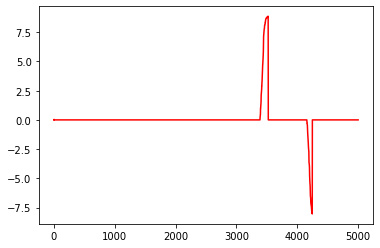

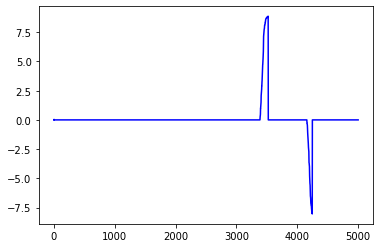

In [5]:
plt.plot(y_change[0:5000], color="red")
plt.show()
plt.plot(clean_y_change[0:5000], color="blue")

plt.show()

plt.plot(x_change[0:5000], color="red")
plt.show()
plt.plot(clean_x_change[0:5000], color="blue")

plt.show()

plt.plot(z_change[0:5000], color="red")
plt.show()
plt.plot(clean_z_change[0:5000], color="blue")

In [ ]:
# Alarms detected with median
for i in x_closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in x_opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(x_median[0:50000], color="blue")

plt.show()

for i in z_closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in z_opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(z_median[0:50000], color="blue")

plt.show()

for i in y_closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in y_opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(y_median[0:50000], color="blue")

In [ ]:
plt.plot(x_median[0:20000], color="blue")
plt.plot(x_change[0:20000], color="red")

plt.show()

plt.plot(z_median[0:20000], color="blue")
plt.plot(z_change[0:20000], color="red")

plt.show()

plt.plot(y_median[0:20000], color="blue")
plt.plot(y_change[0:20000], color="red")

In [ ]:
for i in x_alarms:
    if(i > 3000 and i < 5000):
        plt.axvline(x=i-3000, color='red', linestyle='-')
plt.plot(x_median[3000:5000], color="blue")
plt.plot(x_change[3000:5000], color="green")

plt.show()

for i in z_alarms:
    if(i > 3000 and i < 5000):
        plt.axvline(x=i-3000, color='red', linestyle='-')
plt.plot(z_median[3000:5000], color="blue")
plt.plot(z_change[3000:5000], color="green")

In [ ]:
plt.plot(z[490000:500000], color="blue")
plt.plot(z_median[490000:500000], color="red")

In [ ]:
plt.plot(z_change, color="red")

### Detect open/closed

In [ ]:
state = "unknown"
state_list = list([state])

for i in range(1, len(x_change)):
    if(x_change[i] == 0 and x_change[i-1] > 0): state = "open"
    elif(x_change[i] == 0 and x_change[i-1] < 0): state = "closed"
    
    state_list.append(state)

In [ ]:
for i in range(0, len(state_list[0:5000])):
    if(state_list[i] == "open"):
        plt.axvline(x=i, color='green', linestyle='-')
plt.plot(x[0:5000], color="blue")
        

### Compare results

### Clean

In [ ]:
a = 0
b = 5000

plt.plot(clean_x_change[a:b], color="blue")
plt.show()
plt.plot(clean_y_change[a:b], color="red")
plt.show()
plt.plot(clean_z_change[a:b], color="green")

In [ ]:
plt.show()

plt.plot(x_change[0:500000], color="red")
plt.show()
plt.plot(clean_x_change[0:500000], color="blue")

In [ ]:
plt.plot(x_change[0:20000], color="blue")
plt.show()
plt.plot(x[0:20000], color="blue")


In [ ]:
plt.plot(y_change[0:5000], color="blue")
for i in localMin_list:
    plt.axvline(x=i, color='green', linestyle='-')
plt.show()


In [ ]:
plt.plot(y_change[0:500000], color="red")
plt.show()
plt.plot(clean_y_change[0:500000], color="blue")

plt.show()

plt.plot(x_change[0:500000], color="red")
plt.show()
plt.plot(clean_x_change[0:500000], color="blue")

plt.show()

plt.plot(z_change[0:500000], color="red")
plt.show()
plt.plot(clean_z_change[0:500000], color="blue")


In [39]:
### Clean change (remove errors online)

clean_y_change = list([y_change[0]])
globalMax_y = -1
globalMin_y = 100000
lastZero_y = 0   # Last zero before movement

clean_x_change = list([x_change[0]])
globalMax_x = 0
globalMin_x = 100000
lastZero_x = 0   # Last zero before movement

clean_z_change = list([z_change[0]])
globalMax_z = 0
globalMin_z = 100000
lastZero_z = 0   # Last zero before movement

coef1 = 1.2
coef2 = 0.5


def removeMaxTop(i, cleanChange):
    j = i - 1
    while(cleanChange[j] > 0 and j > 0):
        cleanChange[j] = 0
        j -= 1

def removeMinTop(i, cleanChange):
    j = i - 1
    while(cleanChange[j] < 0 and j > 0):
        cleanChange[j] = 0
        j -= 1
        
def deleteSmallTops(lastZero, cleanChange, globalMax, coef2, position):
    j = lastZero                                  # Delete movements smallers that 50% global maximim
    while(j > 0): 
        try:
            if(position == "max"):
                if(cleanChange[j] < globalMax*coef2): cleanChange[j] = min(0, cleanChange[j])
            elif(position == "min"):
                if(cleanChange[j] > globalMax*coef2): cleanChange[j] = max(0, cleanChange[j])
        except:
            print("error at: ",j)
        j -= 1

def isLocalMax(i, change):
    return change[i] == 0 and change[i-1] > 0

def updateLastZero(i, change, lastZero):
    if(change[i] == 0): lastZero = i
        
def isLocalMin(i, change):
    return change[i] == 0 and change[i-1] < 0

localTop_list = list()

for i in range(1, len(y_change[0:50000])):
    
    if(y_change[i] == 0): lastZero_y = i                         # Update Last zero     
    localMax = isLocalMax(i, y_change)                          # Check if position is a local maximum
    
    if(localMax):
        localTop_list.append(i)
        isGlobal = y_change[i-1] > globalMax_y*coef1  # Local maximum is global
        deleteTop = y_change[i-1] > globalMin_y*coef2
        
        if (isGlobal):    
            print("global: ", i)
            print("lastZero", lastZero_y)
            print("----")
            globalMax_y = y_change[i-1]
            deleteSmallTops(lastZero_y, clean_y_change, globalMax_y, coef2, "max")
            
        elif(deleteTop):                 # Local top is not global and smaller than 50% global: delete
            
            localTop_list.append(i)
            removeMaxTop(i, clean_y_change)
    
    localMin = isLocalMin(i, y_change)
    if(localMin): 
        isGlobal = y_change[i-1] < globalMin_y*coef1
        deleteTop = y_change[i-1] > globalMin_y*coef2
        
        if (isGlobal):                   # Local minimum is global
            globalMin_y = y_change[i-1]
            deleteSmallTops(lastZero_y, clean_y_change, globalMin_y, coef2, "min")
            
        elif(deleteTop):                  # Local min is not global and smaller than 50% global: delete
            removeMinTop(i, clean_y_change)
    
      ####
    
    
    clean_y_change.append(y_change[i])



error at:  253
global:  610
lastZero 610
----
error at:  610
global:  4238
lastZero 4238
----
error at:  4238


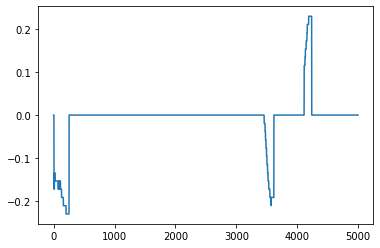

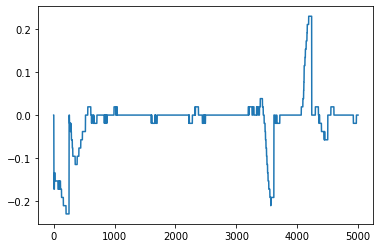

In [41]:
plt.plot(clean_y_change[0:5000])
plt.show()
plt.plot(y_change[0:5000])


In [26]:
# y_change[i-1] > globalMin_y*coef2


20 * 0.2

4.0